In [17]:
import pandas as pd
import featuretools as ft
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, cross_val_score
import numpy as np
from tpot import TPOTClassifier
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import balanced_accuracy_score
import joblib  # 用于保存交互项模式和模型
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report

from lightgbm import LGBMClassifier
import lightgbm as lgb

In [48]:
X_y_group_train = pd.read_csv('./mid_data/X_y_group_train_updated_v12.2.7_piecewise_quadratic_regression.csv')

print("Adding numeric labels y")
le = LabelEncoder()
X_y_group_train["y"] = le.fit_transform(X_y_group_train["label"])
# reordering columns:
X_y_group_train = X_y_group_train[["dataset", "variable"] + X_y_group_train.columns.drop(["dataset", "variable", "label", "y"]).tolist() + ["label", "y"]]


blacklist = ["ttest(v,X)", "pvalue(ttest(v,X))<=0.05", "ttest(v,Y)", "pvalue(ttest(v,Y))<=0.05", "ttest(X,Y)", "pvalue(ttest(X,Y))<=0.05"]
columns_to_drop = [col for col in blacklist if col in X_y_group_train.columns]
X_y_group_train = X_y_group_train.drop(columns=columns_to_drop)

numeric_columns = X_y_group_train.select_dtypes(include=[np.number]).columns
X_y_group_train[numeric_columns] = X_y_group_train[numeric_columns].fillna(X_y_group_train[numeric_columns].mean())

display(X_y_group_train)

print("Extracting X_train, y_train, and group")
X_train = X_y_group_train.drop(["variable", "dataset", "label", "y"], axis="columns")

y_train = X_y_group_train["y"]
group_train = X_y_group_train["dataset"]

Adding numeric labels y


,dataset,variable,dimension,"corr(v,X)","corr(v,Y)","max(corr(v, others))","min(corr(v, others))","mean(corr(v, others))","std(corr(v, others))","corr(X,Y)",...,v~X_piecewise_coef3,v~X_piecewise_coef4,v~Y_piecewise_coef3,v~Y_piecewise_coef4,X~v_piecewise_coef3,X~v_piecewise_coef4,Y~v_piecewise_coef3,Y~v_piecewise_coef4,label,y
0,0,0,8,0.169735,-0.113595,0.791467,0.027355,0.282376,0.298969,-0.771058,...,-0.015912,1.857140,-0.398531,-2.087772,0.048087,0.367993,0.647120,-0.797267,Consequence of Y,5
1,0,2,8,-0.072334,0.139419,0.230139,0.003233,0.090511,0.082201,-0.771058,...,0.314202,-0.067089,-0.109696,0.329777,0.539706,-0.796044,-1.029111,0.940233,Independent,6
2,0,3,8,0.123115,-0.238769,0.781051,0.012225,0.257037,0.288165,-0.771058,...,-0.774869,0.705936,0.663168,-0.574398,-0.581388,-0.368196,-0.334205,0.681756,Cause of Y,1
3,0,4,8,-0.001935,0.013921,0.147408,0.001935,0.052451,0.053457,-0.771058,...,0.053241,0.515599,-0.165054,-0.431895,-0.484305,0.040165,-1.054304,-0.105632,Cause of Y,1
4,0,5,8,0.284323,-0.466570,0.791467,0.064815,0.426306,0.250048,-0.771058,...,0.024392,0.614038,0.678395,-0.551876,-0.638695,-0.368382,-0.493728,0.471341,Mediator,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142905,46997,6,7,0.014740,0.697089,0.748635,0.013858,0.376630,0.352655,-0.089641,...,-1.363617,-0.337637,1.965855,1.091103,-0.603187,0.061220,-0.458500,-0.199052,Cause of Y,1
142906,46997,7,7,-0.007397,-0.116481,0.998843,0.007397,0.180741,0.333308,-0.089641,...,0.107449,0.794534,0.067102,-0.251452,-0.145545,0.310907,1.551589,-0.350345,Cause of Y,1
142907,46997,8,7,-0.011658,0.908029,0.970364,0.011658,0.469777,0.441105,-0.089641,...,-0.322729,0.096514,0.334285,-0.903728,-0.843334,0.216771,-0.200540,-0.365379,Cause of Y,1
142908,46998,0,2,0.083546,-0.019665,0.083546,0.016856,0.040022,0.037719,0.036862,...,-0.169169,0.358553,-0.132776,-0.306132,1.455105,2.273112,-0.814299,0.178171,Consequence of X,4


Extracting X_train, y_train, and group


In [49]:
import re

def clean_feature_names(X):
    # 定义特殊字符到可接受字符的映射
    char_map = {
        '(': 'a', ')': 'b', '[': 'c', ']': 'd', '{': 'e', '}': 'f',
        '<': 'g', '>': 'h', '=': 'i', '+': 'j', '-': 'k', '*': 'l',
        '/': 'm', '\\': 'n', '|': 'o', '&': 'p', '^': 'q', '%': 'r',
        '$': 's', '#': 't', '@': 'u', '!': 'v', '~': 'w', '`': 'x',
        ':': 'y', ';': 'z', ',': 'A', '.': 'B', '?': 'C', "'": 'D',
        '"': 'E', ' ': '_'  # 空格替换为下划线
    }

    def clean_name(name):
        # 使用映射替换特殊字符
        for char, replacement in char_map.items():
            name = name.replace(char, replacement)
        
        # 确保名称不以数字开头
        if name[0].isdigit():
            name = 'f_' + name
        return name

    X.columns = [clean_name(col) for col in X.columns]
    return X

# 清理特征名称
X_train = clean_feature_names(X_train)

Best LGBM Pharamter now:
```python
model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=29,
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    device='gpu',
    gpu_platform_id=1,
    gpu_device_id=0,
)
```

v12.1分数:0.6559
objective='multiclassova',
0.6567



In [50]:
# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [51]:




model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=29,
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    device='cpu',
    gpu_platform_id=1,
    gpu_device_id=0,
)
display(model)

# 定义回调函数
callbacks = [lgb.log_evaluation(period=1), lgb.early_stopping(stopping_rounds=10)]

# 训练模型
model.fit(X_train, y_train, callbacks=callbacks, eval_set=[(X_test, y_test)])

# 预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 计算平衡准确率
train_score = balanced_accuracy_score(y_train, y_train_pred)
test_score = balanced_accuracy_score(y_test, y_test_pred)

print(f"Train balanced accuracy: {train_score:.6f}")
print(f"Test balanced accuracy: {test_score:.6f}")

# 输出详细的分类报告
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, device='cpu',
               gpu_device_id=0, gpu_platform_id=1, learning_rate=0.05,
               max_depth=7, n_estimators=2000, n_jobs=-1, num_leaves=29,
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.7)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32968
[LightGBM] [Info] Number of data points in the train set: 114328, number of used features: 151
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[1]	valid_0's multi_logloss: 1.9449
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.84169
[3]	valid_0's multi_logloss: 1.75276
[4]	valid_0's multi_logloss: 1.67828
[5]	valid_0's multi_logloss: 1.61448
[6]	valid_0's multi_logloss: 1.

0.684907


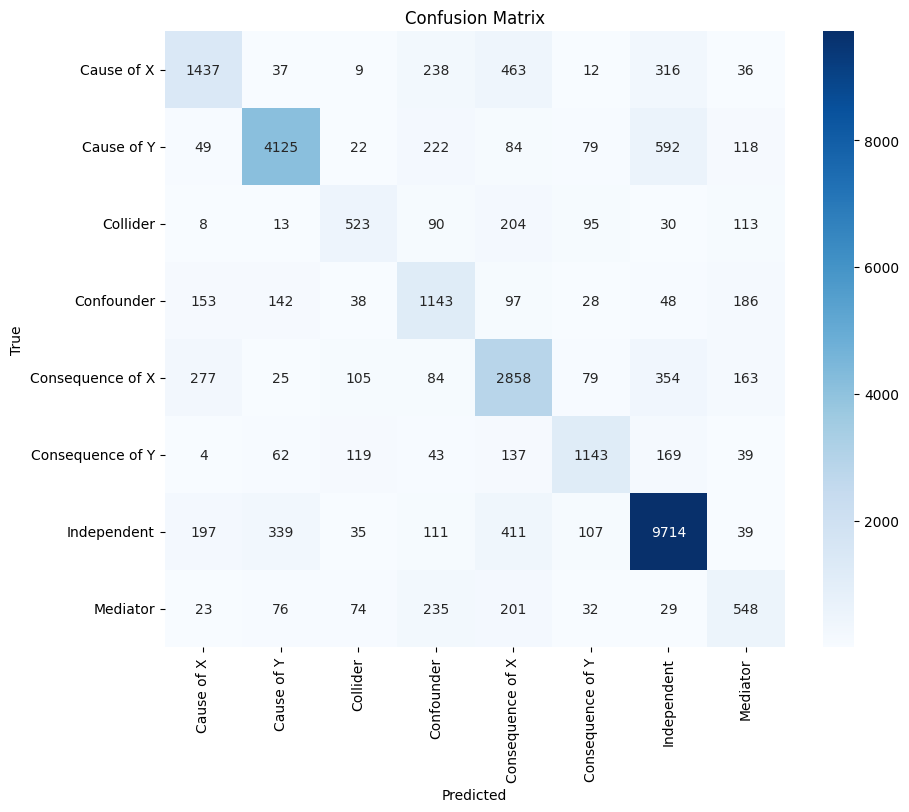

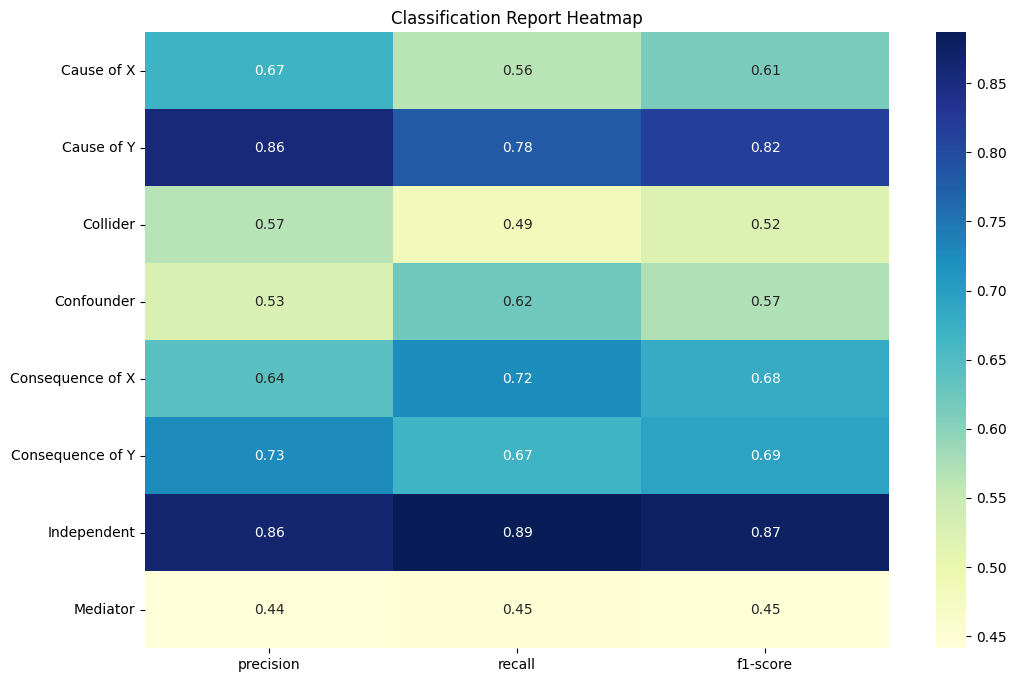

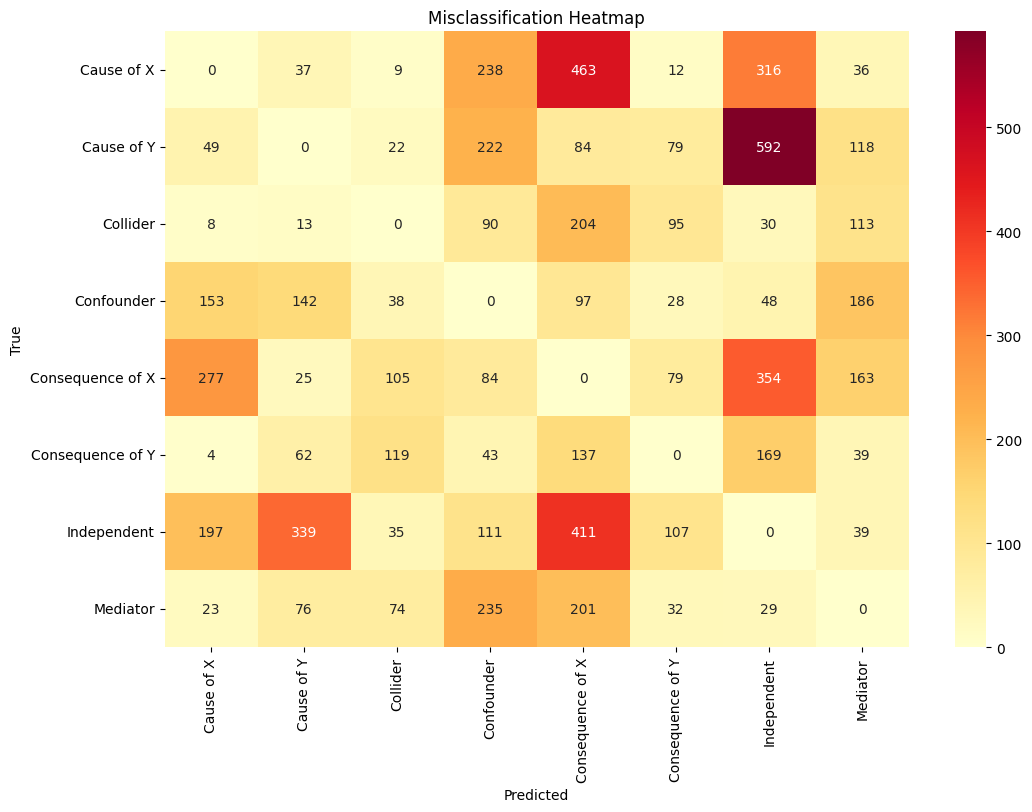

Most common misclassifications:
True              Predicted       
Cause of Y        Independent         592
Cause of X        Consequence of X    463
Independent       Consequence of X    411
Consequence of X  Independent         354
Independent       Cause of Y          339
Cause of X        Independent         316
Consequence of X  Cause of X          277
Cause of X        Confounder          238
Mediator          Confounder          235
Cause of Y        Confounder          222
dtype: int64


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 假设我们已经有了预测结果 y_pred 和真实标签 y_true
# 如果没有,请先运行模型得到预测结果

# 1. 计算混淆矩阵

y_true = y_test
y_pred = y_test_pred

cm = confusion_matrix(y_true, y_pred)

# 2. 创建混淆矩阵热力图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 3. 计算每个类别的精确度、召回率和F1分数
report = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)

# 4. 创建分类报告可视化
df_report = pd.DataFrame(report).transpose()
plt.figure(figsize=(12, 8))
sns.heatmap(df_report.iloc[:-3, :-1].astype(float), annot=True, cmap='YlGnBu')
plt.title('Classification Report Heatmap')
plt.show()

# 5. 分析错误分类情况
misclassified = y_true != y_pred
error_df = pd.DataFrame({
    'True': le.inverse_transform(y_true[misclassified]),
    'Predicted': le.inverse_transform(y_pred[misclassified])
})
error_counts = error_df.groupby(['True', 'Predicted']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(error_counts, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Misclassification Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 打印最常见的错误分类情况
print("Most common misclassifications:")
print(error_df.groupby(['True', 'Predicted']).size().sort_values(ascending=False).head(10))